<h1>6. Machine Learning für Zeitreihen: Überblick & Klassifikation</h1>
<h4>Session 6 (Freitag 11:00 – 12:30)</h4>
<br>
6.1 Besonderheiten Machine Learning für Zeitreihen<br>
6.2 Datenvorbereitung: Merkmalsbestimmung (Feature extraction), ...<br>
6.3 Klassifikation in Zeitreihendaten<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import tree

<h2>7.1 Random Forest Klassifikation mit Zeitreihen: Belegungserkennung aus Temperatur-, Feuchte-, Licht- und CO2-Messungen</h2>

<h3> Datensatz einlesen </h3>

In [2]:
occ = pd.read_csv("occupancy.txt")
occ['date'] = pd.to_datetime(occ['date'])
occ.set_index('date', inplace=True)
occ.columns = ['Temperatur','Feuchte','Licht','CO2','Feuchte-Ratio','Belegt']
occ.head()
#occ.info()
#occ.describe()

,Temperatur,Feuchte,Licht,CO2,Feuchte-Ratio,Belegt
date,,,,,,
2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


Text(0, 0.5, 'Belegt?')

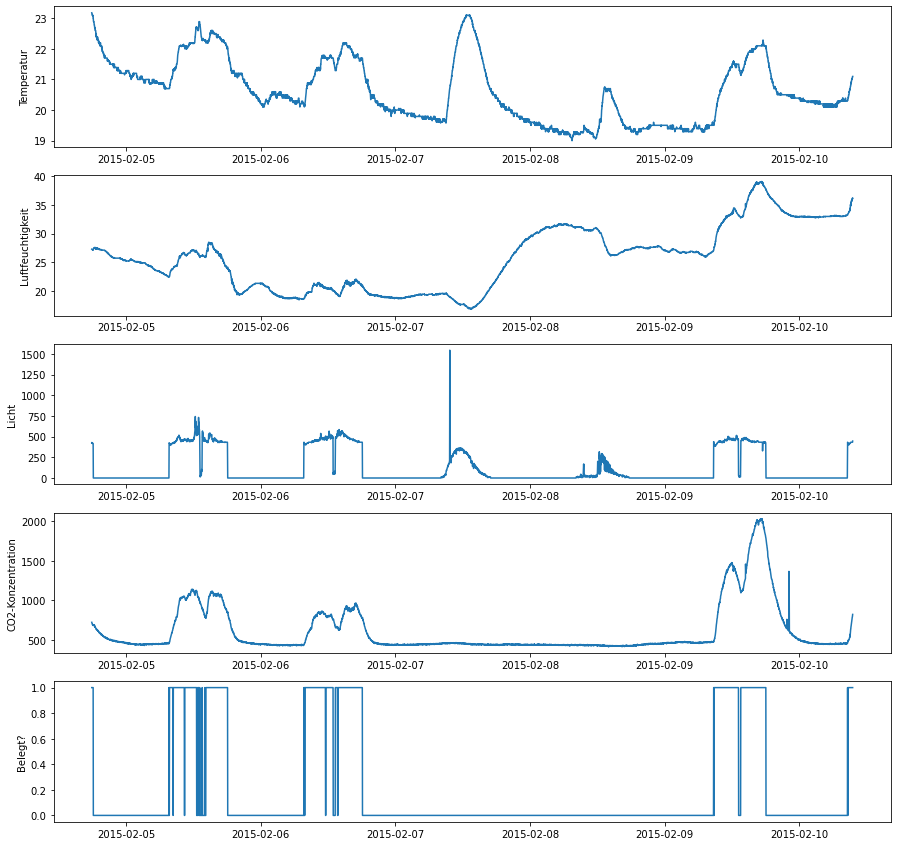

In [3]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(15,15))
ax1.plot(occ['Temperatur'])
ax1.set_ylabel("Temperatur")
ax2.plot(occ['Feuchte'])
ax2.set_ylabel("Luftfeuchtigkeit")
ax3.plot(occ['Licht'])
ax3.set_ylabel("Licht")
ax4.plot(occ['CO2'])
ax4.set_ylabel("CO2-Konzentration")
ax5.plot(occ['Belegt'])
ax5.set_ylabel("Belegt?")

In [4]:
occ["hour"] = occ.index.hour
occ["weekday"] = occ.index.weekday

occ.head()

,Temperatur,Feuchte,Licht,CO2,Feuchte-Ratio,Belegt,hour,weekday
date,,,,,,,,
2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1,17,2
2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1,17,2
2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1,17,2
2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1,17,2
2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1,17,2


In [5]:
occ.loc[(occ['hour'] < 20) & (occ['hour'] > 7) & (occ['weekday'] < 5), 'workinghours'] = 'True'
occ["Arbeitszeit"] = pd.get_dummies(occ['workinghours'])

occ.head()

,Temperatur,Feuchte,Licht,CO2,Feuchte-Ratio,Belegt,hour,weekday,workinghours,Arbeitszeit
date,,,,,,,,,,
2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1,17,2,True,1
2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1,17,2,True,1
2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1,17,2,True,1
2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1,17,2,True,1
2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1,17,2,True,1


In [6]:
occ = occ.drop(['Feuchte-Ratio','hour','weekday','workinghours'], axis = 1)
occ = occ.reindex(columns=['Temperatur','Feuchte','Licht','CO2','Arbeitszeit','Belegt'])

occ.head()
#occ.info()
#occ.describe()

,Temperatur,Feuchte,Licht,CO2,Arbeitszeit,Belegt
date,,,,,,
2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,1,1
2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,1,1
2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,1,1
2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,1,1
2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,1,1


<h3> Trainings- und Testdaten (70%:30%, zufällig) </h3>

In [7]:
labels = np.array(occ['Belegt'])
features = occ.drop(['Belegt'], axis = 1)
feature_list = list(features.columns)
features = np.array(features)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.3, random_state = 42)
X_test.shape

(2443, 5)

<h3> Model mit Trainingsdaten trainieren - wie wichtig sind einzelne Merkmale? </h3>

In [8]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

RandomForestClassifier()

In [9]:
feature_imp = pd.DataFrame(clf.feature_importances_,index=feature_list)
feature_imp

,0
Temperatur,0.076009
Feuchte,0.026653
Licht,0.500484
CO2,0.190208
Arbeitszeit,0.206647


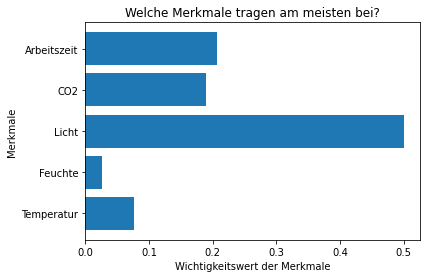

In [10]:
plt.barh(feature_imp.index,feature_imp[0])
plt.xlabel('Wichtigkeitswert der Merkmale')
plt.ylabel('Merkmale')
plt.title("Welche Merkmale tragen am meisten bei?")
plt.show()

<h3> Testdaten klassifizieren - wie gut ist unser Klassifikator? </h3>

In [11]:
y_pred=clf.predict(X_test)
print("Unser Random-Forest-Klassifizierer klassifiziert korrekt:",metrics.accuracy_score(y_test, y_pred))

Unser Random-Forest-Klassifizierer klassifiziert korrekt: 0.9967253376995497


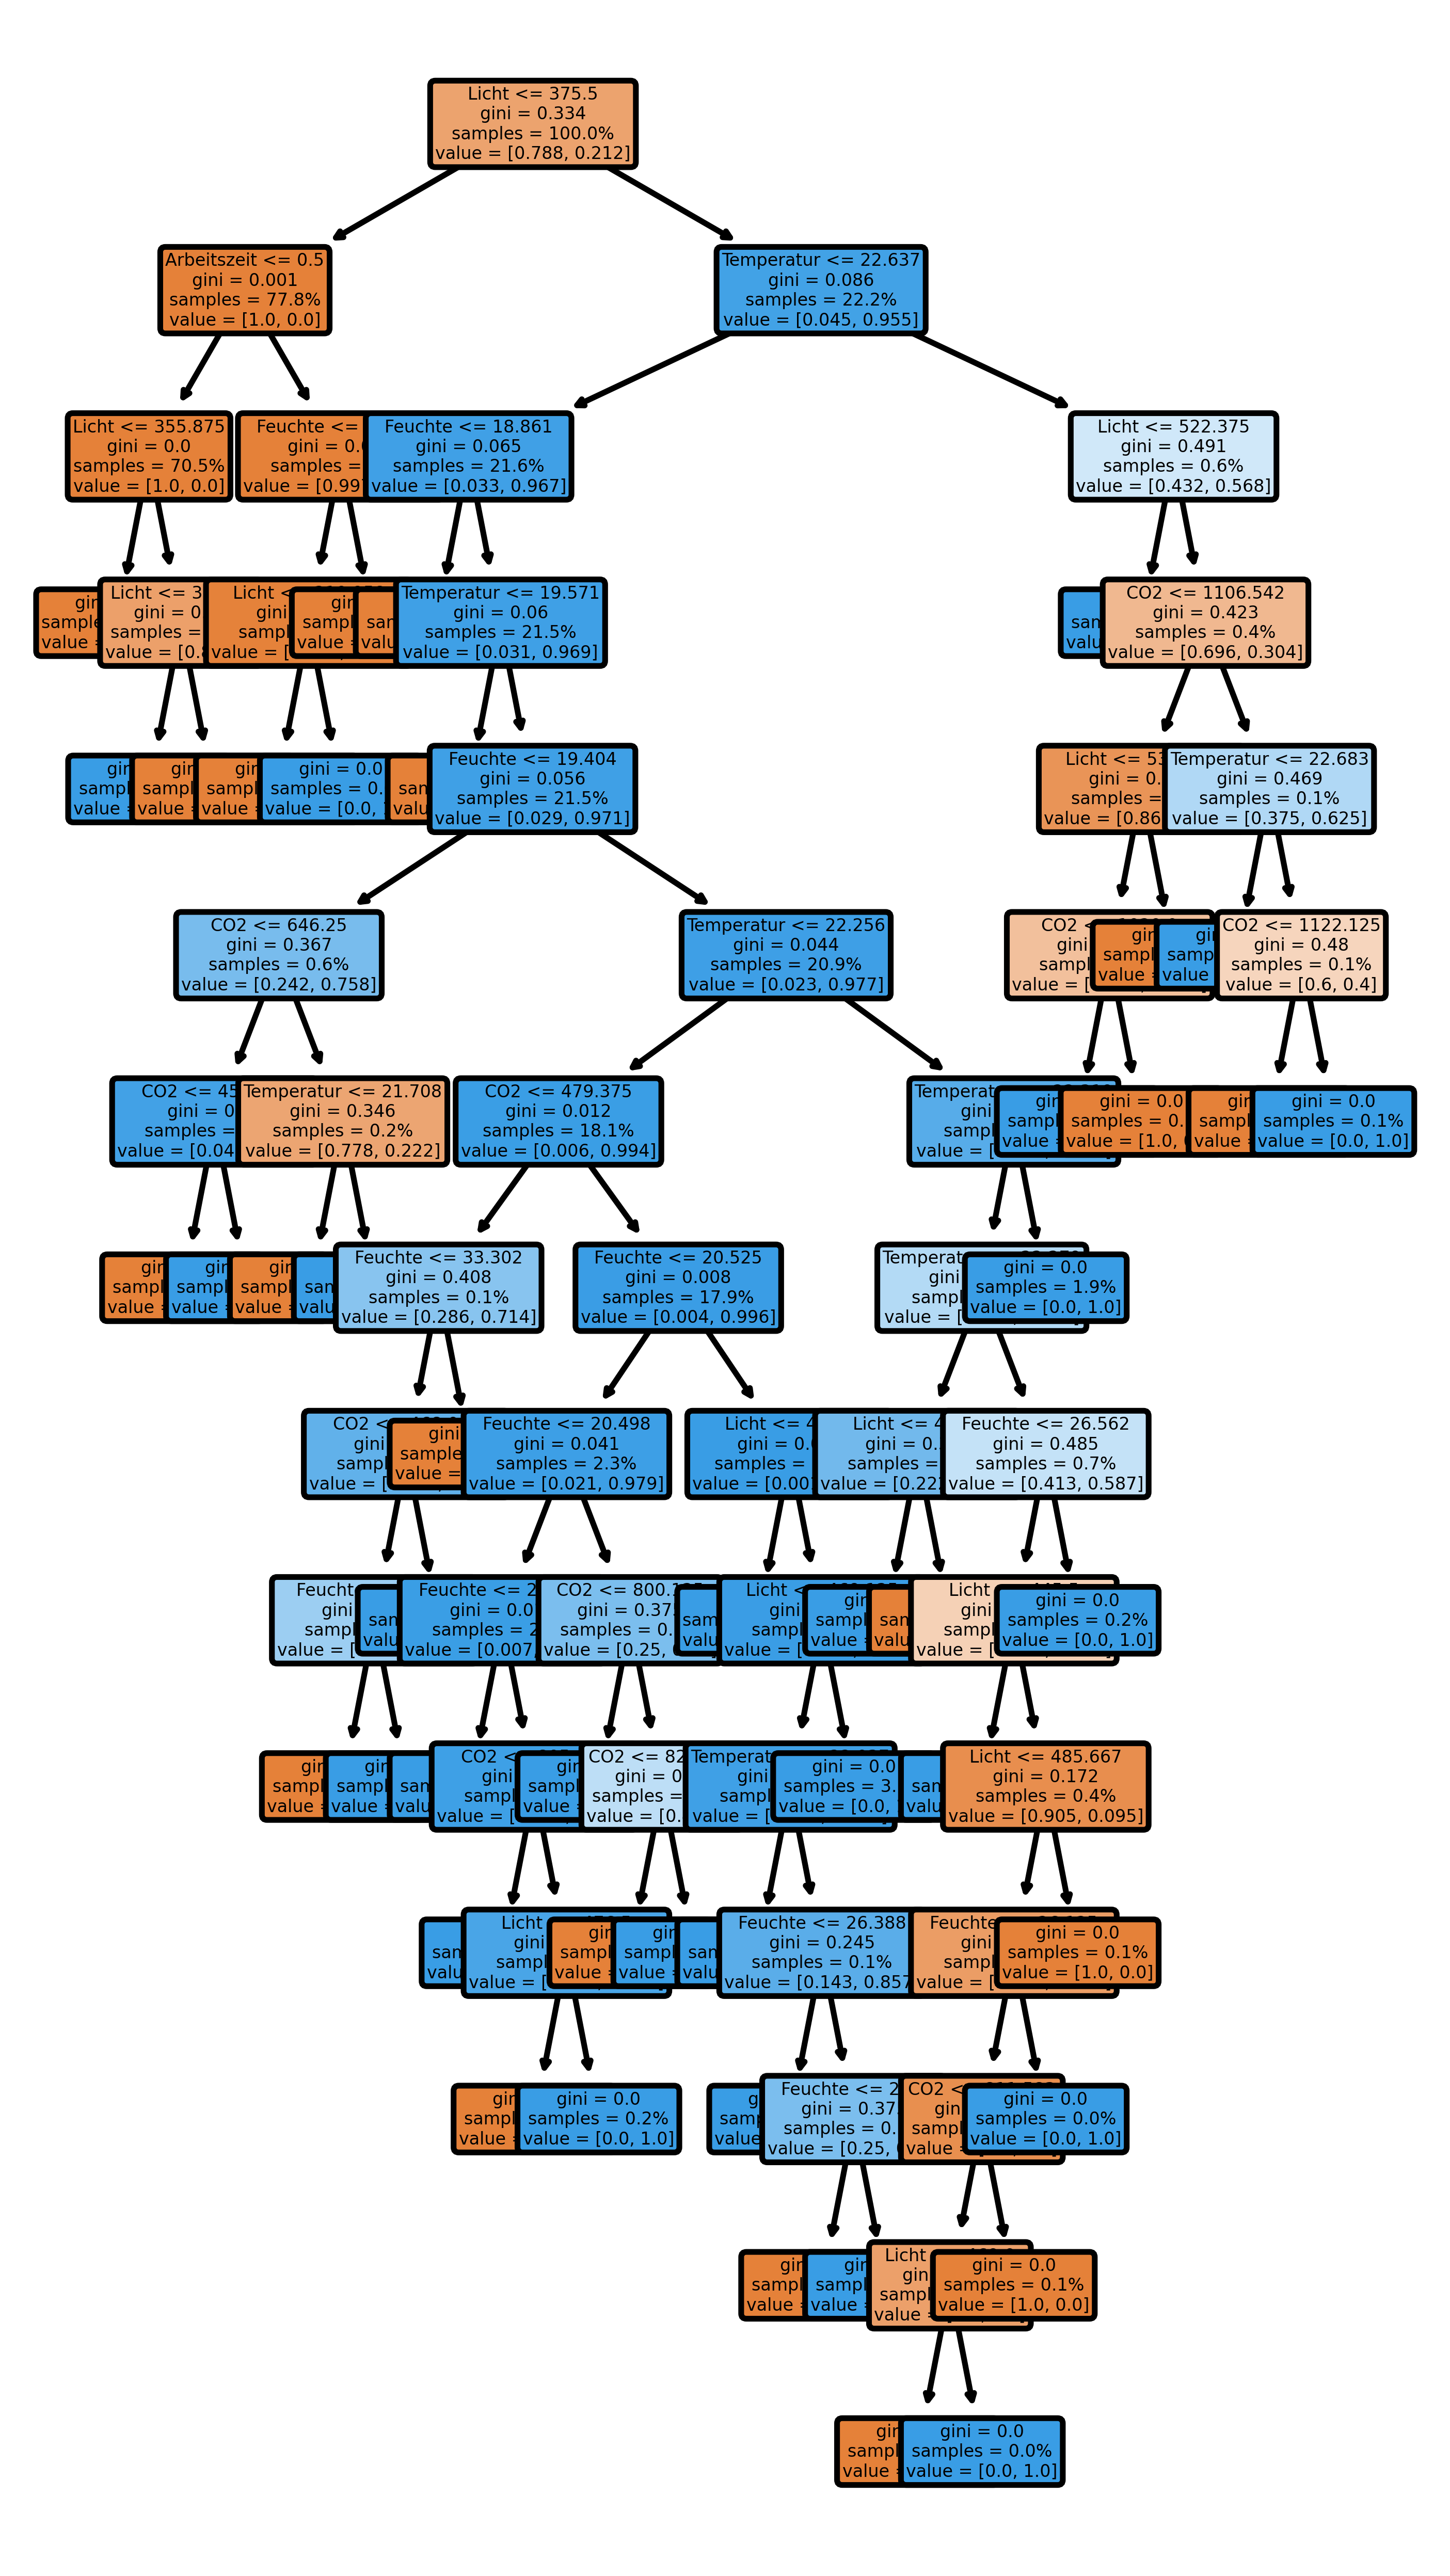

In [12]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,8), dpi=800)
tree.plot_tree(clf.estimators_[2], feature_names = feature_list, filled = True, proportion = True, rounded = True, fontsize=3);
fig.savefig('rf_einbaum.png')

<div class="alert alert-info">
- Versuche mit einem anderen Datensatz, eine ähnliche Klassifikation durchzuführen<br>
- Plotte dazu die Daten und entscheide, welche Features du in die Klassifikation aufnehmen willst<br>
- Teile deine Daten in Trainings- und Testdaten<br>
- Trainiere einen Random Forest Klassifikator und klassifiziere deine Testdaten<br>
- Welche Features sind am wichtigsten? Wie viel Prozent werden korrekt klassifiziert?
</div>

In [13]:
new = pd.read_csv('Occupancy_Estimation.csv')
new.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1
